In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd
import json

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 65.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 5.1 MB/s eta 0:00:0000:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
#!pip install git+https://github.com/fkunstner/dataset-downloader.git

In [2]:
DATASETS = ['a1a', 'mushrooms', 'a6a', 'w1a', 'w5a', 'ionosphere']
METHODS = ['SGD', 'AdaSpider', 'Spider', 'SpiderBoost', 'SVRG', 'AdaGrad', 'AdaSVRG']

In [3]:
import os
import sys
module_path = "/home/ec2-user/SageMaker/ML-Reproducibility-Challange/"
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from sklearn.preprocessing import Normalizer
from sklearn import *

# Logistic regression

In [14]:
# for dataset_name in DATASETS:
#     X, y = get_data(dataset_name)
#     pd.DataFrame(np.c_[X, y]).to_csv(f"{dataset_name}.csv", index=False)

In [15]:
from src.optimizers.Optimizer import Optimizer

In [22]:
def get_data(dataset_name: str):
    """
    :param dataset_name: Name of the dataset from dsdl module.
    :return: (X, y) train and target data.
    """
    ds = dsdl.load(dataset_name)
    X, y = ds.get_train()
    X = X.toarray()
    y = y.reshape(-1, 1)
    return normalize(X, y)

def normalize(X, y):
    scaler_x = Normalizer().fit(X)
    X_scaled = scaler_x.transform(X)
    
    scaler_y = Normalizer().fit(y)
    y_scaled = scaler_y.transform(y)
    return X_scaled, y_scaled

def build_model(X, y):
    """
    Joins weights
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.zeros((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.zeros(shape=(tx.shape[1], 1))

def test_method(method: Optimizer,
                initial_weights,
                tx,
                y,
                max_iter: int,
                *parameter):
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        gradients, loss = method.optimize(initial_weights, tx, y, max_iter)
        return [np.linalg.norm(grad)**2 for grad in gradients], loss

In [23]:
from src.optimizers.SGD import SGD  # works
from src.optimizers.AdaSpider import AdaSpider
from src.optimizers.Spider import Spider  # works
from src.optimizers.SpiderBoost import SpiderBoost
from src.optimizers.SVRG import SVRG
from src.optimizers.AdaGrad import AdaGrad # works
from src.optimizers.AdaSVRG import AdaSVRG

In [29]:
N_ORACLE_CALLS = 0

METHODS = [
    # SGD(lambda_=0.0001, q=N_ORACLE_CALLS),
    # AdaSpider(q=1500),
    #Spider(n_0 = 0.0005, lambda_=5e-05, epsilon=5e-05, q=3000),
    SpiderBoost(lambda_=0.1, q=3000),
    SVRG(lambda_=0.0001, q=4000),
    AdaGrad(lambda_=0.0001, q=N_ORACLE_CALLS),
    AdaSVRG(lambda_=0.0001, q=5000)
]  

## Run simulations

In [25]:
# run 2 # 20 mins on 8 cpu avs ml.c5.2xlarge
# run 1 # 1 hour later on the 4 cpu machine 
# started at 17:50 4th dataset
# 17:57

In [32]:
ITERATIONS = 100000
N_RUNS = 1

all_gradients = []

datasets_data = {}
for i, dataset_name in enumerate([DATASETS[3]]):

    print("Dataset", dataset_name)

    X, y = get_data(dataset_name)
    tx = build_model(X, y)
    initial_weights = get_initial_weights(tx)
    methods_data = {}
    for method in METHODS:
        print("Method", method.name)
        
        if method.name in ['SGD', 'AdaGrad']:
            N_RUNS = 3
        else:
            N_RUNS = 1
        
        gradients_5_runs = list()
        for runn in range(N_RUNS):
            print(runn)
            gradients, _ = test_method(method, initial_weights, tx, y, ITERATIONS)
            gradients_5_runs.append(gradients)
        gradients_mean = np.mean(gradients_5_runs, axis=0)

        stddev = np.std(gradients_5_runs, axis=0)
        lower = gradients_mean - stddev
        upper = gradients_mean + stddev

        methods_data[method.name] = {
            "gradient_mean": list(gradients_mean),
            "lower": list(lower),
            "upper": list(upper),
            "n_runs": N_RUNS,
            "n_iterations": ITERATIONS,
            "gradient_calls": method.q
        }
        datasets_data[dataset_name] = methods_data

    break  # plot single dataset
print("DONE")

Dataset w1a
Method SpiderBoost
0
0.00022025461433417025 2270.1000000000004
0
3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000
42000
45000
48000
51000
54000
57000
60000
63000
66000
69000
72000
75000
78000
81000
84000
87000
90000
93000
96000
99000
Method SVRG
0
Step size 0.00044052861495468644
Full grad, iter: 0 0.19860492504952287


KeyboardInterrupt: 

In [35]:
print("done")

done


In [33]:
datasets_data["w1a"].keys()

dict_keys(['SpiderBoost'])

In [34]:
with open('run_all_20_12_100k_w1a_spiderboost.json', 'w') as file:
    json.dump(datasets_data, file)

In [17]:
print('DONE')

DONE


In [26]:
# with open('run_all_20_12_200k_a1a.json', 'r') as file:
#     datasets_data1 = json.load(file)

In [27]:
# datasets_data['a1a'] = datasets_data1['a1a']

In [73]:
# datasets_data['a1a']['SGD'] = datasets_data1['a1a']['SGD']
# datasets_data['a1a']['AdaSpider'] = datasets_data1['a1a']['AdaSpider']

In [74]:
# with open('run_all_19_12_150k_spider_spiderboost.json', 'r') as file:
#     datasets_data2 = json.load(file)
    
# with open('run_all_19_12_40k.json', 'r') as file:
#     datasets_data1 = json.load(file)
    

In [75]:
# datasets_data1['a1a']['Spider']['gradient_mean'] = datasets_data2['a1a']['Spider']['gradient_mean']
# datasets_data1['a1a']['SpiderBoost']['gradient_mean'] = datasets_data2['a1a']['SpiderBoost']['gradient_mean']

In [11]:
# gradients = list(range(1,11))

# new_list = []

# ITERATIONS=100
# q = 2

# for idx in range(len(gradients)):
#     new_list.append(gradients[idx])
#     new_list.extend([None for _ in range(10)])

### Plot

Dataset a1a
Method Spider
Method SpiderBoost
Method SVRG
Method AdaGrad
Method AdaSVRG
Method SGD
Method AdaSpider
Dataset mushrooms
Method Spider
Method SpiderBoost
Method SVRG
Method AdaGrad
Method AdaSVRG


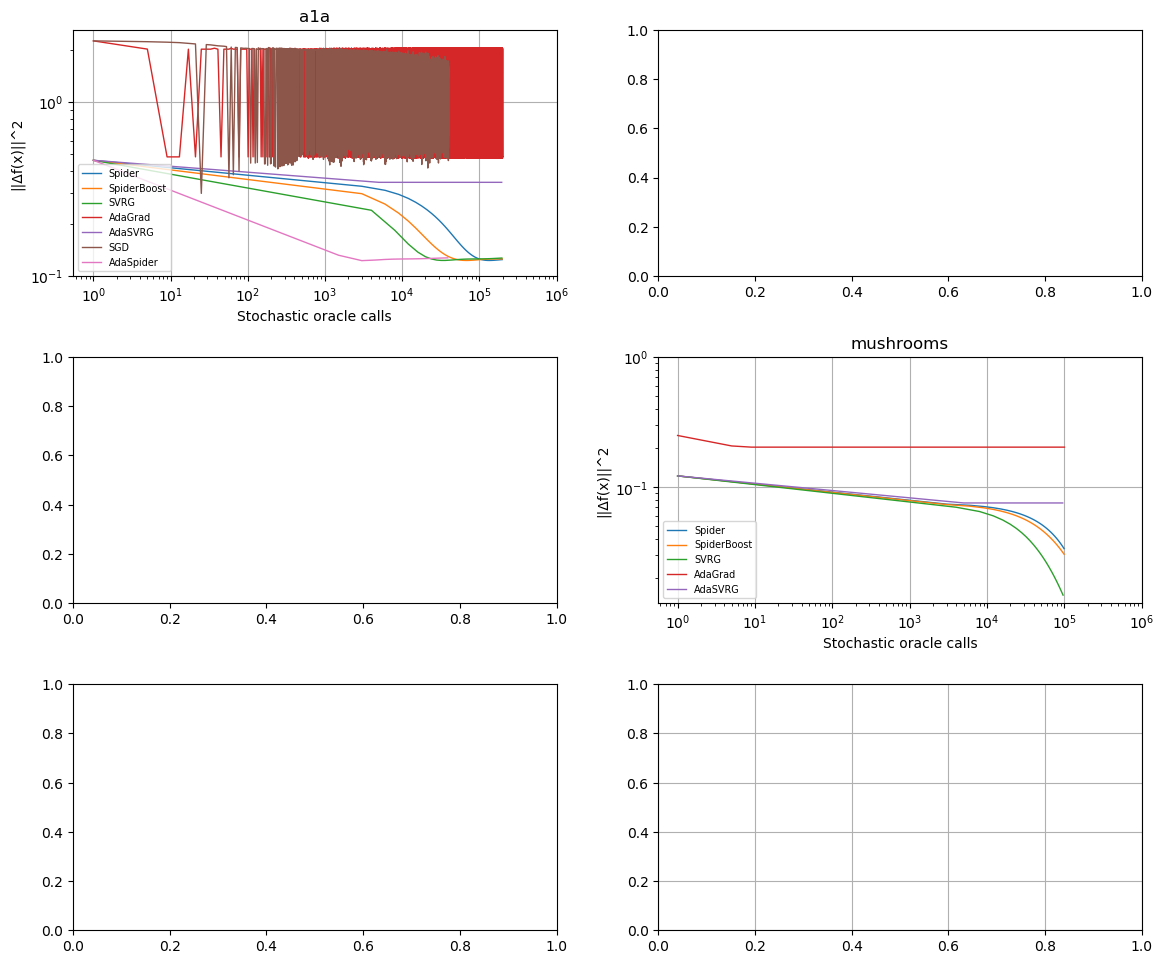

In [32]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharey=False, sharex=False)  # 3, 2

for i, dataset_name in enumerate(DATASETS):
    print("Dataset", dataset_name)

    methods_data = datasets_data[dataset_name]

    sbplt = ax[i%3, i%2]

    for method_name, method_data in methods_data.items():
        print("Method", method_name)
        gradients_mean = method_data['gradient_mean']
        
        
        lower = method_data['lower']
        upper = method_data['upper']
        n_iterations = method_data['n_iterations']
        gradient_calls = method_data['gradient_calls']
        
        if gradient_calls != 0:  
            grad_x = [(gradient_calls*n)+1 for n in range(len(gradients_mean))]
            sbplt.plot(grad_x, gradients_mean, label=method_name, linewidth=1)
        else:
            gradients_mean = gradients_mean[0::4]
            grad_x = [(4*n)+1 for n in range(len(gradients_mean))]
            sbplt.plot(grad_x, gradients_mean, label=method_name, linewidth=1)
        
        # sbplt.fill_between(grad_y, lower, upper, alpha=0.25,
        #                    facecolor='red', edgecolor='red')

    plt.grid(True, which='both')
    
    sbplt.set_xscale('log')
    sbplt.set_yscale('log')
    # sbplt.set_xticks([1, 10, 100, 1000, 10000, 100000])
    sbplt.set_xticks([pow(10, e) for e in range(0, 7, 1)])
    sbplt.set_yticks([pow(10, e) for e in range(-1, 1, 1)])
    sbplt.set_title(dataset_name)
    
    sbplt.grid(True)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left', fontsize='x-small')
    

    if i == 1:
        break
        

fig.tight_layout(pad=2.0)
fig.savefig(f'tests_logistic_regression_all_complete.jpg', dpi=300)

# plot_data()

## Do parameter sweep

In [53]:
powers = np.array([range(-5, 0)], dtype=float)
parameters = 10**powers.flatten()

In [54]:
parameters

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [55]:
from itertools import product

In [56]:
len(list(product(parameters, parameters, parameters)))

125

In [ ]:
DF_COLUMNS = ['method_name', 'loss', 'parameters']
df = pd.DataFrame(columns=DF_COLUMNS)

In [80]:
# N_ORACLE_CALLS = 150

METHODS = [
    # SGD(lambda_=0.0001, q=N_ORACLE_CALLS),
    # AdaSpider(q=N_ORACLE_CALLS),
    Spider(n_0 = 0.0005, lambda_=5e-05, epsilon=5e-05, q=3000),
    SpiderBoost(lambda_=1000, q=3000),
    # SVRG(lambda_=0.0001, q=5000),
    # AdaGrad(lambda_=0.0001, epsilon= 0.0001, q=N_ORACLE_CALLS),
    # AdaSVRG(lambda_=0.01, epsilon = 0.0001, q=4000)
]

dataset_name = 'a1a'
ITERATIONS = 5000
print("Dataset", dataset_name, "Iterations: ", ITERATIONS)

powers = np.array([range(-5, 5)], dtype=float)
parameters = 5*10**powers.flatten()

X, y = get_data(dataset_name)
tx = build_model(X, y)
initial_weights = get_initial_weights(tx)

print("Parameters values: ", parameters)

for method in METHODS[3:]:
    if method.n_params_to_tune == 2:
        for param in list(product(parameters, parameters)):
            method.set_params(param[0], param[1])
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method, np.sum(losses), str(param)])), ignore_index=True)
            print('done', param, method.name, np.sum(losses))
            
    elif method.n_params_to_tune == 3:
        for param in list(product(parameters, parameters))[10:]:
            method.set_params(param[0], 5e-05, param[1])
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)
            print('done', param, method, np.sum(losses))
    
    elif method.n_params_to_tune == 1:
        for param in parameters:
            method.set_params(param)
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)
            print('done', param, method, np.sum(losses))
            
    else:
        param = None
        _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
        df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)
        print('done', param, method, np.sum(losses))
    

Dataset a1a Iterations:  5000
Parameters values:  [5.e-05 5.e-04 5.e-03 5.e-02 5.e-01 5.e+00 5.e+01 5.e+02 5.e+03 5.e+04]
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 5e-05) AdaSVRG 3463.809840881291
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 0.0005) AdaSVRG 1943674.02753144
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 0.005) AdaSVRG -321412.367520976
Full grad, iter: 0


/root/ML-Reproducibility-Challange/src/logistic_regression/sigmoid.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-t))


Full grad, iter: 4000
done (5e-05, 0.05) AdaSVRG -3737040.9637916703
Full grad, iter: 0


/root/ML-Reproducibility-Challange/src/logistic_regression/log_reg.py:40: RuntimeWarning: overflow encountered in exp
  first_component = np.log(1 + np.exp(tx.dot(w)))


Full grad, iter: 4000
done (5e-05, 0.5) AdaSVRG inf
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 5.0) AdaSVRG -222166220.44176072
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 50.0) AdaSVRG -2222328549.02094
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 500.0) AdaSVRG -22198773195.353203
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 5000.0) AdaSVRG -222202185679.1651
Full grad, iter: 0
Full grad, iter: 4000
done (5e-05, 50000.0) AdaSVRG -2220362967585.124
Full grad, iter: 0
Full grad, iter: 4000
done (0.0005, 5e-05) AdaSVRG 3463.809833309784
Full grad, iter: 0
Full grad, iter: 4000
done (0.0005, 0.0005) AdaSVRG 1939912.6441696836
Full grad, iter: 0
Full grad, iter: 4000
done (0.0005, 0.005) AdaSVRG -222782.83819701133
Full grad, iter: 0
Full grad, iter: 4000
done (0.0005, 0.05) AdaSVRG -1938349.5712126154
Full grad, iter: 0
Full grad, iter: 4000
done (0.0005, 0.5) AdaSVRG inf
Full grad, iter: 0
Full grad, iter: 4000
done (0.0005, 5.0) AdaSVRG -221962667

In [83]:
df.to_csv("param_run_19_12.csv", index=False)

In [25]:
df = pd.read_csv("param_run_19_12.csv")

In [28]:
df[df.method_name == "Spider"]

,method_name,loss,parameters
0,Spider,-686.949064,"(5e-05, 5e-05, 5e-05)"
1,Spider,-687.024908,"(5e-05, 5e-05, 0.0005)"
2,Spider,-687.000072,"(5e-05, 5e-05, 0.005)"
3,Spider,-686.925763,"(5e-05, 5e-05, 0.05)"
4,Spider,-685.740359,"(5e-05, 5e-05, 0.5)"
5,Spider,-675.442067,"(5e-05, 5e-05, 5.0)"
6,Spider,-573.581975,"(5e-05, 5e-05, 50.0)"
7,Spider,226.716132,"(5e-05, 5e-05, 500.0)"
8,Spider,2383.402366,"(5e-05, 5e-05, 5000.0)"
9,Spider,3322.717889,"(5e-05, 5e-05, 50000.0)"


In [95]:
df.to_csv("parameters_sweep_spider.csv", index=False)

,method_name,loss,parameters
0,Spider,-6.869491e+02,"(5e-05, 5e-05, 5e-05)"
1,Spider,-6.870249e+02,"(5e-05, 5e-05, 0.0005)"
2,Spider,-6.870001e+02,"(5e-05, 5e-05, 0.005)"
3,Spider,-6.869258e+02,"(5e-05, 5e-05, 0.05)"
4,Spider,-6.857404e+02,"(5e-05, 5e-05, 0.5)"
...,...,...,...
235,<src.optimizers.AdaSVRG.AdaSVRG object at 0x7f...,-2.219917e+08,"(50000.0, 5.0)"
236,<src.optimizers.AdaSVRG.AdaSVRG object at 0x7f...,-2.221614e+09,"(50000.0, 50.0)"
237,<src.optimizers.AdaSVRG.AdaSVRG object at 0x7f...,-2.221078e+10,"(50000.0, 500.0)"
238,<src.optimizers.AdaSVRG.AdaSVRG object at 0x7f...,-2.221040e+11,"(50000.0, 5000.0)"


In [94]:
df['loss'].abs().idxmin(), df['loss'].abs().min()

(7, 226.71613212255397)

In [208]:
df.iloc[4]

method_name    SpiderBoost
loss            635.058059
parameters             0.5
Name: 4, dtype: object

In [209]:
df

,method_name,loss,parameters
0,SpiderBoost,635.058469,5e-05
1,SpiderBoost,635.058385,0.0005
2,SpiderBoost,635.059386,0.005
3,SpiderBoost,635.059539,0.05
4,SpiderBoost,635.058059,0.5
5,SpiderBoost,635.070119,5.0
6,SpiderBoost,635.175792,50.0
7,SpiderBoost,636.221395,500.0
8,SpiderBoost,644.830861,5000.0
9,SpiderBoost,673.275301,50000.0


In [91]:
from copy import copy

In [93]:
df_2 = copy(df)
df_2['loss'] = df_2['loss'].abs()
df_2.groupby('method_name').min()

,loss,parameters
method_name,,
<src.optimizers.AdaSVRG.AdaSVRG object at 0x7f6aad8de410>,3463.300303,"(0.0005, 0.0005)"
AdaSVRG,3463.479083,"(0.0005, 0.0005)"
SVRG,1108.383014,0.0005
Spider,226.716132,"(0.0005, 0.0005)"
SpiderBoost,2213.296677,0.0005


In [65]:
# METHODS = ['AdaSpider', 'Spider']
# ITERATIONS = 100
#
# def plot_data():
#     # Write your code to make 4x4 panel here
#     X_LABEL = "Stochastic oracle calls"
#     Y_LABEL = "||\u0394f(x)||^2"
#
#     fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)
#
#     for i, dataset_name in enumerate(DATASETS):
#         sbplt = ax[i%3, i%2]
#         print(dataset_name)
#         for method in METHODS:
#             if method == "Spider":
#                 spider_params = SpiderParam(100, 5, 0.05)
#                 gradients = test_method(Spider, dataset_name, ITERATIONS, spider_params)
#             else:
#                 gradients = test_method(ADASpider, dataset_name, ITERATIONS)
#             gradients = [np.linalg.norm(grad, 2) for grad in gradients]
#             sbplt.plot(gradients, label=method)
#
#         sbplt.set_xscale('log')
#         sbplt.set_title(dataset_name)
#         sbplt.set_xlabel(X_LABEL)
#         sbplt.set_ylabel(Y_LABEL)
#         sbplt.legend(loc='lower left')
#
#         break  # plot single dataset
#
#     fig.tight_layout(pad=2.0)
#     # fig.savefig('tests_logistic_regression.jpg', dpi=150)
#
# plot_data()